Training period: 2020-01-01 to 2020-11-27
Testing period: 2020-12-01 to 2020-12-31
Training Accuracy: 0.6129032258064516
Testing Accuracy: 0.4444444444444444

Classification Report:
              precision    recall  f1-score   support

           0       0.44      1.00      0.62         4
           1       0.00      0.00      0.00         5

    accuracy                           0.44         9
   macro avg       0.22      0.50      0.31         9
weighted avg       0.20      0.44      0.27         9



C:\Users\kyloc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kyloc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kyloc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


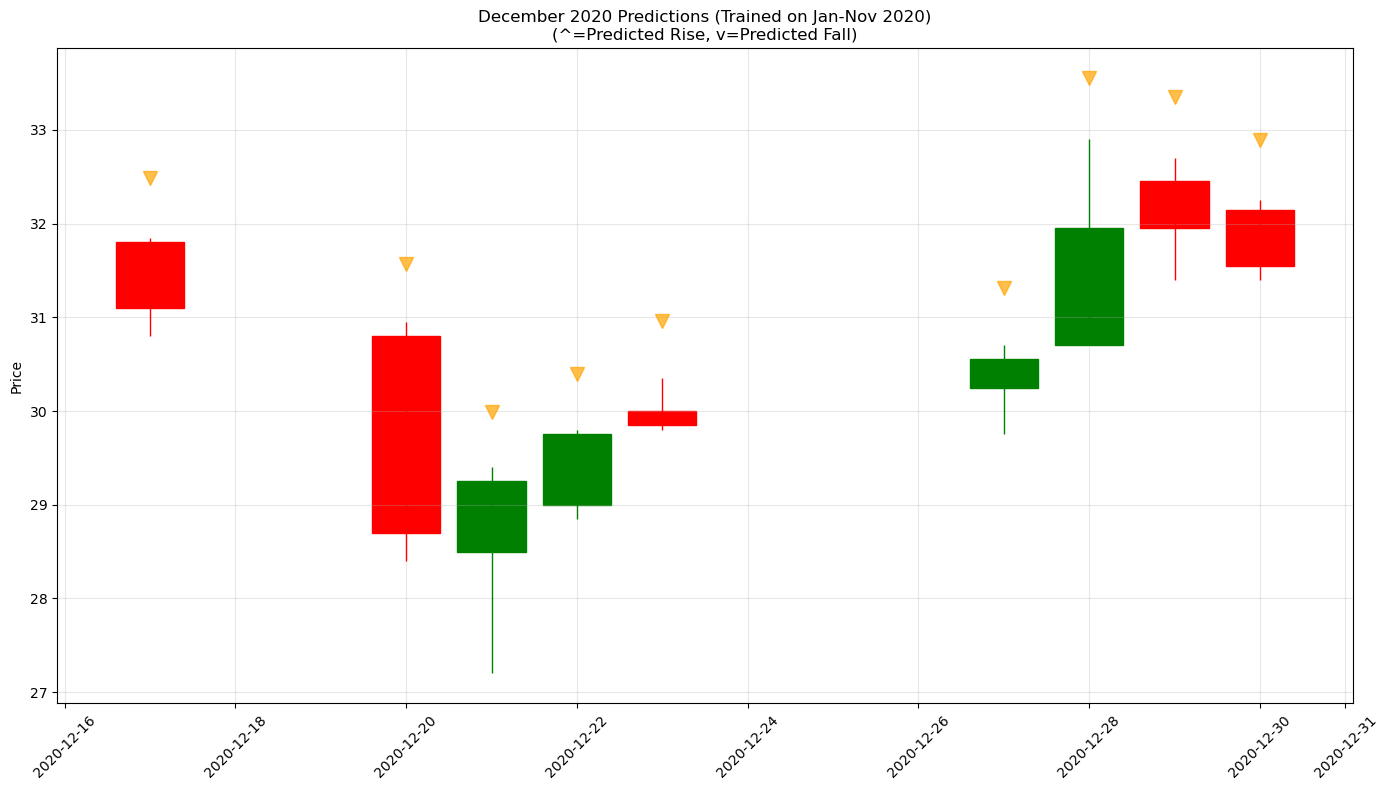

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

def prepare_data(df):
    """Prepare data for machine learning"""
    # Calculate daily returns
    df['daily_return'] = df['close'].pct_change()
    
    # Create target variable (1 if price goes up next day, 0 otherwise)
    df['target'] = (df['daily_return'].shift(-1) > 0).astype(int)
    
    # Technical indicators
    df['ma_5'] = df['close'].rolling(5).mean()
    df['ma_10'] = df['close'].rolling(10).mean()
    df['rsi'] = compute_rsi(df['close'], 14)
    df['macd'], df['signal'] = compute_macd(df['close'])
    
    # Drop NA values
    df = df.dropna()
    
    return df

def compute_rsi(series, window=14):
    """Compute Relative Strength Index"""
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def compute_macd(series, fast=12, slow=26, signal=9):
    """Compute MACD indicator"""
    ema_fast = series.ewm(span=fast).mean()
    ema_slow = series.ewm(span=slow).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal).mean()
    return macd, signal_line

def train_model(X_train, y_train, X_test, y_test):
    """Train Logistic Regression model"""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)
    
    # Evaluate
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)
    
    print("Training Accuracy:", accuracy_score(y_train, train_pred))
    print("Testing Accuracy:", accuracy_score(y_test, test_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, test_pred))
    
    return model, scaler, test_pred

def create_combined_chart(dates, actual_data, predictions):
    """Create candlestick chart with prediction markers"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot candlesticks
    for date, row in actual_data.iterrows():
        if row['close'] >= row['open']:
            color = 'green'
            bottom = row['open']
            height = row['close'] - row['open']
        else:
            color = 'red'
            bottom = row['close']
            height = row['open'] - row['close']
        
        ax.add_patch(Rectangle(
            (mdates.date2num(date) - 0.4, bottom),
            0.8, height,
            facecolor=color,
            edgecolor=color
        ))
        ax.vlines(date, row['low'], row['high'], color=color, linewidth=1.0)
    
    # Add prediction markers
    pred_dates = dates
    for date, pred in zip(pred_dates, predictions):
        if pred == 1:  # Predicted up
            ax.plot(date, actual_data.loc[date, 'low'] * 0.98, 
                   '^', color='blue', markersize=10, alpha=0.7)
        else:  # Predicted down
            ax.plot(date, actual_data.loc[date, 'high'] * 1.02, 
                   'v', color='orange', markersize=10, alpha=0.7)
    
    # Formatting
    ax.set_title('December 2020 Predictions (Trained on Jan-Nov 2020)\n(^=Predicted Rise, v=Predicted Fall)')
    ax.set_ylabel('Price')
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    return fig, ax

# Main execution
if __name__ == "__main__":
    # Load data
    df = pd.read_csv('UNIONBANK__EQ__NSE__NSE__MINUTE.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    
    # Resample to daily
    daily_data = df.resample('D').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).dropna()
    
    # Filter for 2020 only
    data_2020 = daily_data[daily_data.index.year == 2020]
    
    # Split into last
    train_data = data_2020[data_2020.index.month < 12]
    test_data = data_2020[data_2020.index.month == 12]
    
    print("Training period:", train_data.index.min().date(), "to", train_data.index.max().date())
    print("Testing period:", test_data.index.min().date(), "to", test_data.index.max().date())
    
    # Prepare data for ML
    ml_train = prepare_data(train_data.copy())
    ml_test = prepare_data(test_data.copy())
    
    # Features and target
    features = ['ma_5', 'ma_10', 'rsi', 'macd', 'signal', 'volume']
    X_train = ml_train[features]
    y_train = ml_train['target']
    X_test = ml_test[features]
    y_test = ml_test['target']
    
    # Train model
    model, scaler, y_pred = train_model(X_train, y_train, X_test, y_test)
    
    # Create visualization
    fig, ax = create_combined_chart(ml_test.index, test_data.loc[ml_test.index], y_pred)
    plt.show()